# Fetching the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp /content/drive/MyDrive/'Breast Cancer Detection'/Dataset.zip Dataset.zip

In [3]:
!unzip -q Dataset.zip -d Dataset/

### Acknowledgements
The original files are located here: http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip

Citation: https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872

# Importing Dependencies

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve
import seaborn as sns

# Constants

In [5]:
BATCH_SIZE = 128
IMAGE_SIZE = 50
CHANNELS = 3
EPOCHS = 15
PATH = 'Dataset/'

# Importing data into a TensorFlow dataset object

We will use the `image_dataset_from_directory` API to load all images into a TensorFlow dataset. [Link to the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [6]:
dataset = image_dataset_from_directory(
    PATH,
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 157572 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['Benign', 'Malignant']

# Visualizing the first batch of images.

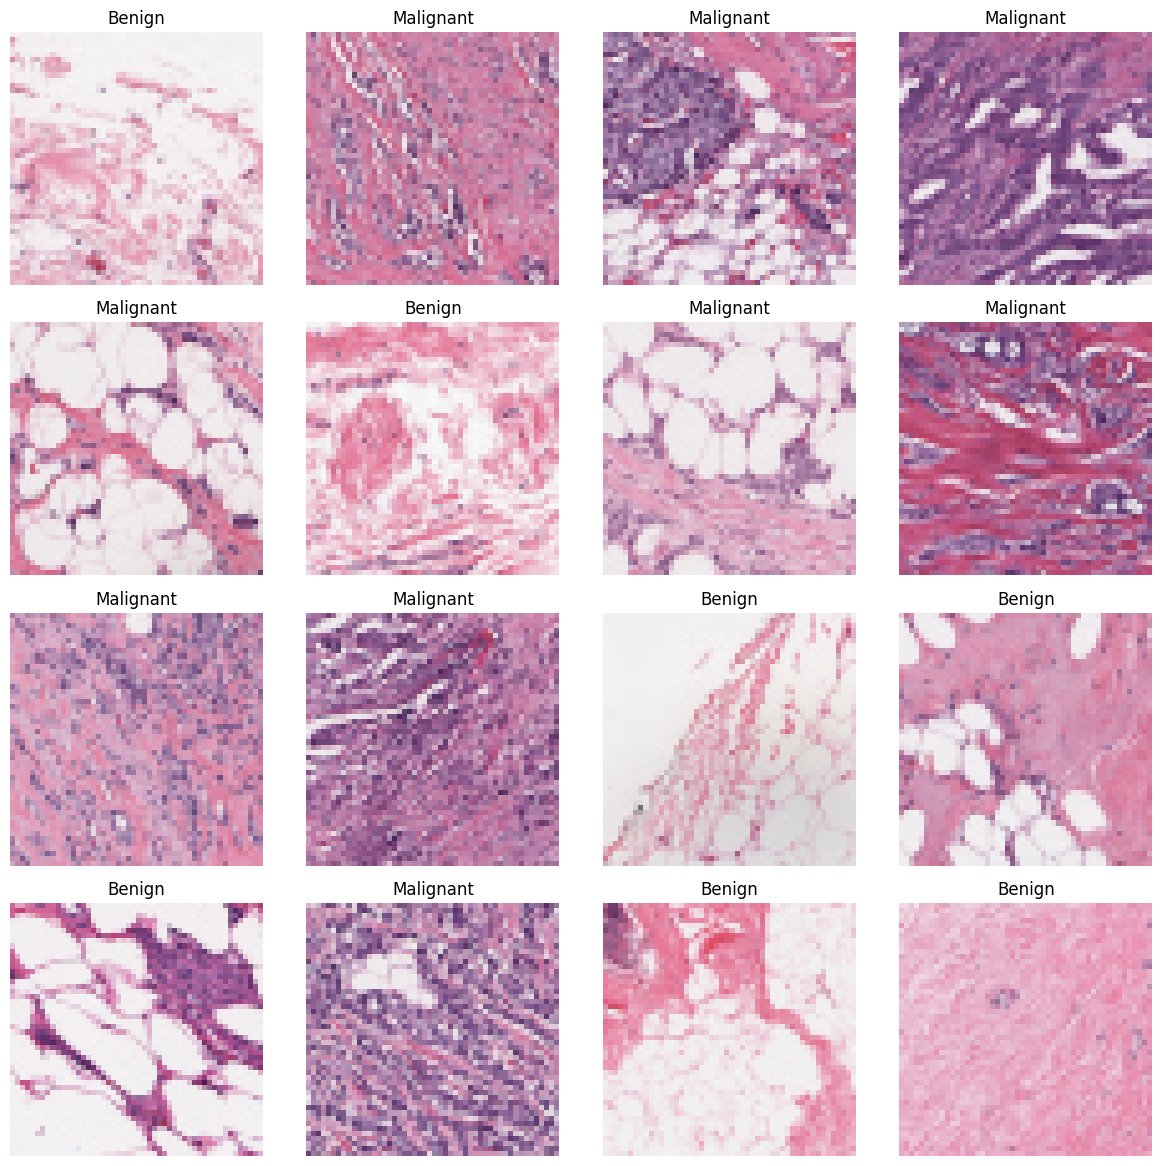

In [8]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Splitting Dataset into Training, Validation, and Testing

In [9]:
TRAIN_SIZE, VALIDATION_SIZE, TESTING_SIZE = 0.6, 0.2, 0.2

In [10]:
train_batch = int(len(dataset) * TRAIN_SIZE)
train_ds = dataset.take(train_batch)

In [11]:
val_batch = int(len(dataset) * VALIDATION_SIZE)
validation_ds = dataset.skip(train_batch).take(val_batch)

In [12]:
test_batch = int(len(dataset) * TESTING_SIZE)
test_ds = dataset.skip(train_batch + val_batch).take(test_batch)

# Building Model

## Resizing and Normalization Layer

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We employ a Convolutional Neural Network (CNN) integrated with a Softmax activation in the output layer. Additionally, our architecture includes foundational layers for resizing, normalization, and Data Augmentation, enhancing overall performance and robustness.

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Dropout(0.1),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 50, 50, 3)          0         
                                                                 
 conv2d (Conv2D)             (128, 48, 48, 32)         896       
                                                                 
 dropout (Dropout)           (128, 48, 48, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (128, 46, 46, 64)         18496     
                                                                 
 conv2d_2 (Conv2D)           (128, 44, 44, 64)         36928     
                                                                 
 dropout_1 (Dropout)         (128, 44, 44, 64)         0         
                                                                 
 conv2d_3 (Conv2D)           (128, 42, 42, 64)        

We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Creating a checkpoint to save the model with the best score.

In [19]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

## Training

In [20]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = validation_ds,
    verbose = 1,
    epochs = EPOCHS,
    callbacks = callback
)

Epoch 1/15
739/739 [==============================] - 119s 149ms/step - loss: 0.4841 - accuracy: 0.7767 - val_loss: 0.4239 - val_accuracy: 0.8134
Epoch 2/15
739/739 [==============================] - 109s 147ms/step - loss: 0.4338 - accuracy: 0.8082 - val_loss: 0.4742 - val_accuracy: 0.7780
Epoch 3/15
739/739 [==============================] - 109s 147ms/step - loss: 0.4084 - accuracy: 0.8222 - val_loss: 0.3680 - val_accuracy: 0.8431
Epoch 4/15
739/739 [==============================] - 93s 126ms/step - loss: 0.3894 - accuracy: 0.8314 - val_loss: 0.3601 - val_accuracy: 0.8480
Epoch 5/15
739/739 [==============================] - 111s 150ms/step - loss: 0.3779 - accuracy: 0.8372 - val_loss: 0.3459 - val_accuracy: 0.8533
Epoch 6/15
739/739 [==============================] - 91s 123ms/step - loss: 0.3697 - accuracy: 0.8424 - val_loss: 0.3549 - val_accuracy: 0.8529
Epoch 7/15
739/739 [==============================] - 94s 127ms/step - loss: 0.3602 - accuracy: 0.8459 - val_loss: 0.3362 - va

In [27]:
! cp model.keras /content/drive/MyDrive/'Breast Cancer Detection'/model.keras

## Loading Model

In [21]:
model = load_model('model.keras')

## Evaluation

### Predict

In [42]:
all_predictions = []
all_labels = []
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

4/4 [==============================] - 0s 8ms/step


### Metrices

In [45]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.8678544207317073
F1 Score:  0.8722326281204901
Recall:  0.8998352762290928
Precision:  0.8462730143597688


### Confusion Matrix

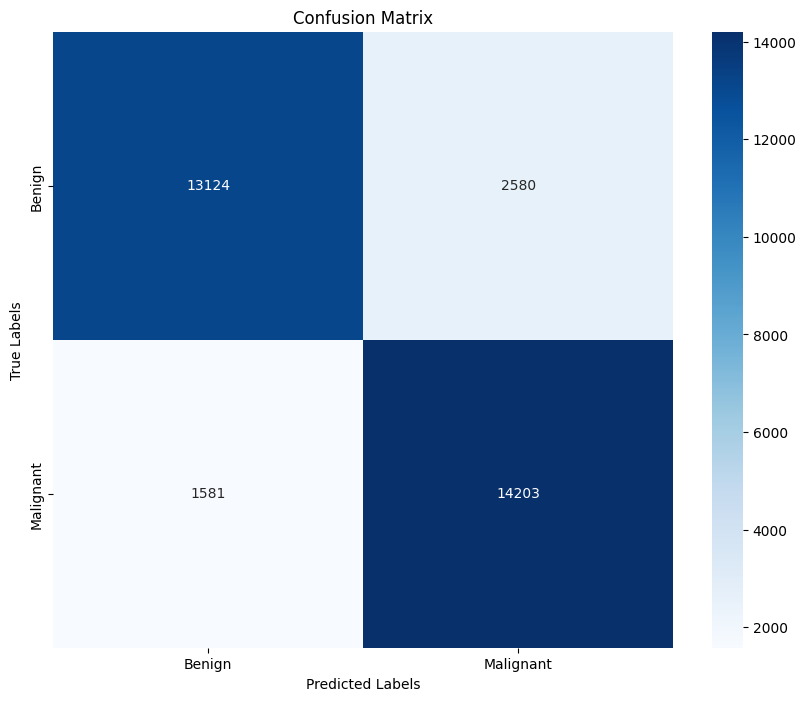

In [43]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Plotting the Accuracy and Loss Curves

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

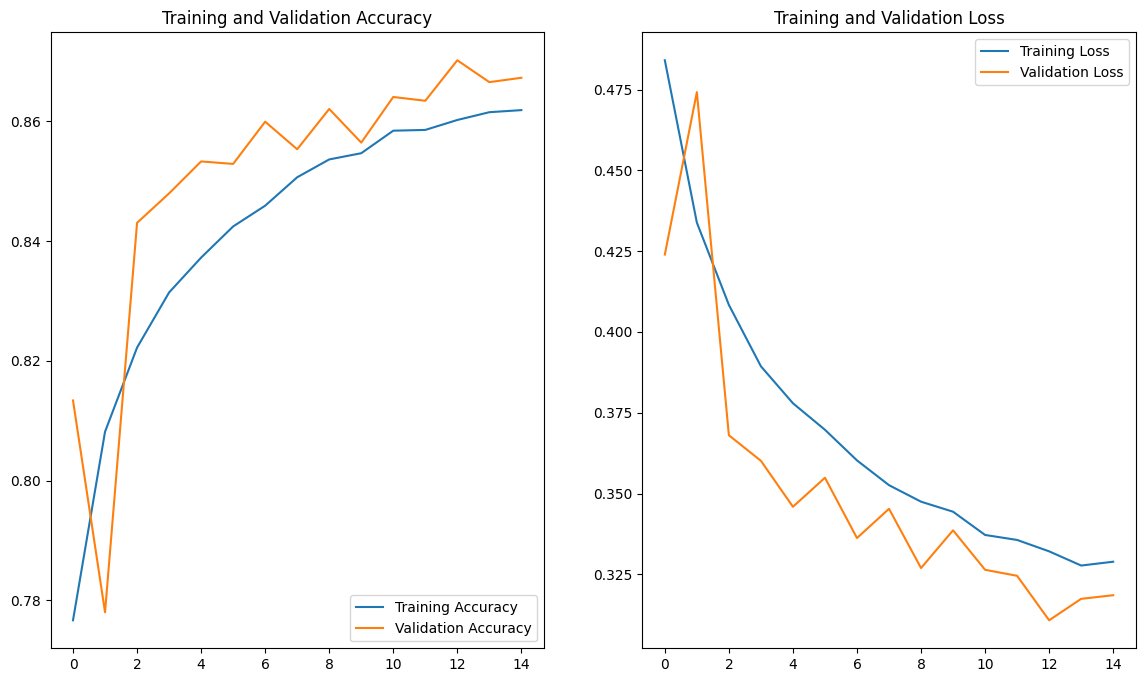

In [24]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Inference



## Inference Function

In [25]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Inference on Sample Images

1/1 [==============================] - 0s 24ms/step


<Figure size 640x480 with 0 Axes>

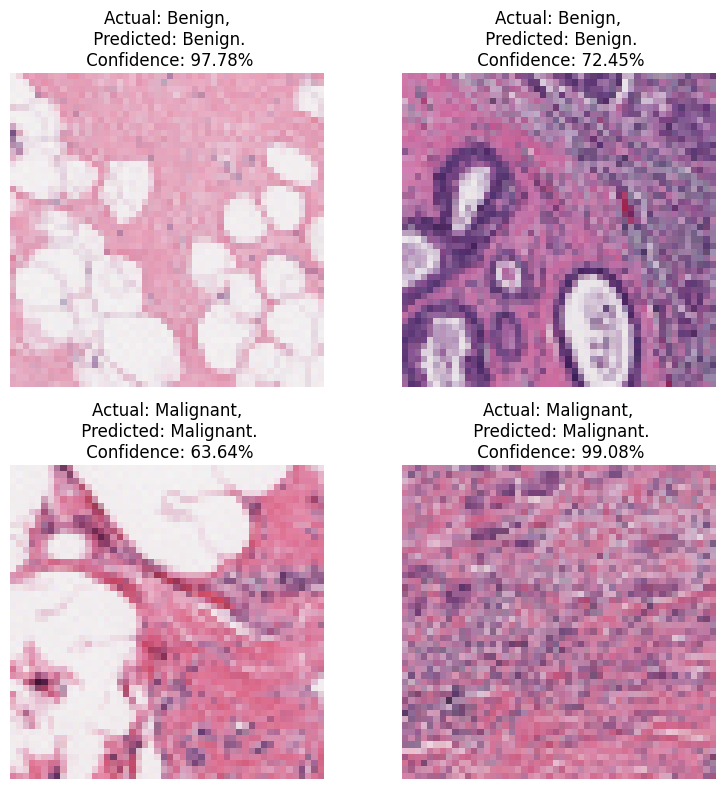

In [39]:
plt.clf()
plt.figure(figsize=(8, 8))
for images, labels in test_ds.take(6):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i])
            actual_class = class_names[labels[i]]

            ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            ax.axis("off")
plt.tight_layout()
plt.show()
